# lab 07 1 learning_rate_and_evaluation - Eager execution
* Learning Rate와 Evaluation에 대한 설명

### 기본 Library 선언 및 TensorFlow 버전 확인

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from mpl_toolkits.mplot3d import Axes3D

tf.random.set_seed(777)  # for reproducibility

print(tf.__version__)

2.1.0


### 강의에 설명할 Data입니다
* x_data가 3차원 배열이기에 3차원 공간에 표현하여 x1과 x2, x3를 기준으로 y_data 3개 클래스를 구분하는 예제입니다
* 해당 Data를 3개의 색상으로 구분해서 출력해 보겠습니다.(파랑-2, 초록-1, 빨강-0)

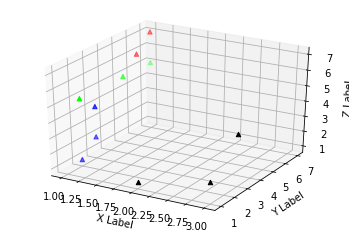

In [2]:
x_train = [[1, 2, 1],
          [1, 3, 2],
          [1, 3, 4],
          [1, 5, 5],
          [1, 7, 5],
          [1, 2, 5],
          [1, 6, 6],
          [1, 7, 7]]

y_train = [[0, 0, 1],
          [0, 0, 1],
          [0, 0, 1],
          [0, 1, 0],
          [0, 1, 0],
          [0, 1, 0],
          [1, 0, 0],
          [1, 0, 0]]

# Evaluation our model using this test dataset
x_test = [[2, 1, 1],
          [3, 1, 2],
          [3, 3, 4]]
y_test = [[0, 0, 1],
          [0, 0, 1],
          [0, 0, 1]]


x1 = [x[0] for x in x_train]
x2 = [x[1] for x in x_train]
x3 = [x[2] for x in x_train]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x1, x2, x3, c=y_train, marker='^')

ax.scatter(x_test[0][0], x_test[0][1], x_test[0][2], c="black", marker='^')
ax.scatter(x_test[1][0], x_test[1][1], x_test[1][2], c="black", marker='^')
ax.scatter(x_test[2][0], x_test[2][1], x_test[2][2], c="black", marker='^')


ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()

##  Tensorflow Eager
### 위 Data를 기준으로 Learning Rate 값과 평가 모델을 만들도록 하겠습니다
* Tensorflow data API를 통해 학습시킬 값들을 담는다 (Batch Size는 한번에 학습시킬 Size로 정한다)
* features,labels는 실재 학습에 쓰일 Data (연산을 위해 Type를 맞춰준다)

In [3]:
dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(len(x_train))#.repeat()

### 위 Data를 기준으로 가설의 검증을 통해 Softmax Classification 모델을 만들도록 하겠습니다
* W와 b은 학습을 통해 생성되는 모델에 쓰이는 Wegith와 Bias (초기값을 variable : 0이나 Random값으로 가능 tf.random_normal([3, 3],tf.zeros([3,3]) )

In [4]:
W = tf.Variable(tf.random.normal((3, 3)))
b = tf.Variable(tf.random.normal((3,)))

### Softmax 함수를 가설로 선언합니다
* Softmax를 통해 가장 높은 값을 구한다 (0~1사이의 값 합계는 1)

In [5]:
def softmax_fn(features):
    hypothesis = tf.nn.softmax(tf.matmul(features, W) + b)
    return hypothesis

### 가설을 검증할 Cost 함수를 정의합니다
* Cross Entropy loss를 사용

In [6]:
def loss_fn(hypothesis, features, labels):
    cost = tf.reduce_mean(-tf.reduce_sum(labels * tf.math.log(hypothesis), axis=1))
    return cost

### Learning Rate 값을 조정하기 위한 Learning Decay 설정 
#### 5개 파라미터 설정
* starter_learning_rate : 최초 학습시 사용될 learning rate (0.1로 설정하여 0.96씩 감소하는지 확인)
* global_step : 현재 학습 횟수
* 1000 : 곱할 횟수 정의 (1000번에 마다 적용)
* 0.96 : 기존 learning에 곱할 값
* 적용유무 decayed_learning_rate = learning_rate * decay_rate ^ (global_step / decay_steps)

In [7]:
is_decay = True
starter_learning_rate = 0.1
    
if(is_decay):    
    learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=starter_learning_rate,
                                                                 decay_steps=1000,
                                                                 decay_rate=0.96,
                                                                 staircase=True)
    optimizer = tf.keras.optimizers.SGD(learning_rate)
else:
    optimizer = tf.keras.optimizers.SGD(learning_rate=starter_learning_rate)

def grad(hypothesis, features, labels):
    with tf.GradientTape() as tape:
        loss_value = loss_fn(softmax_fn(features),features,labels)
    return tape.gradient(loss_value, [W,b])

### 가설을 통해 실재 값과 비교한 정확도를 측정합니다

In [8]:
def accuracy_fn(hypothesis, labels):
    prediction = tf.argmax(hypothesis, 1)
    is_correct = tf.equal(prediction, tf.argmax(labels, 1))
    accuracy = tf.reduce_mean(tf.cast(is_correct, tf.float32))
    return accuracy

### TensorFlow를 통해 학습을 진행합니다.
* 위의 Data를 Cost함수를 통해 학습시킨 후 모델을 생성합니다.
* Test Data값 검증 수행 [2, 1, 1], [3, 1, 2], [3, 3, 4]

In [9]:
EPOCHS = 1001

for step in range(EPOCHS):
    for features, labels  in iter(dataset):
        features = tf.cast(features, tf.float32)
        labels = tf.cast(labels, tf.float32)
        grads = grad(softmax_fn(features), features, labels)
        optimizer.apply_gradients(grads_and_vars=zip(grads,[W,b]))
        if step % 100 == 0:
            print("Iter: {}, Loss: {:.4f}".format(step, loss_fn(softmax_fn(features),features,labels)))
x_test = tf.cast(x_test, tf.float32)
y_test = tf.cast(y_test, tf.float32)
test_acc = accuracy_fn(softmax_fn(x_test),y_test)
print("Testset Accuracy: {:.4f}".format(test_acc))

Iter: 0, Loss: 7.8510
Iter: 100, Loss: 0.6915
Iter: 200, Loss: 0.5892
Iter: 300, Loss: 0.5326
Iter: 400, Loss: 0.4927
Iter: 500, Loss: 0.4615
Iter: 600, Loss: 0.4358
Iter: 700, Loss: 0.4139
Iter: 800, Loss: 0.3951
Iter: 900, Loss: 0.3785
Iter: 1000, Loss: 0.3638
Testset Accuracy: 1.0000
